In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

file_name = 'SDS00003.csv'
df = pd.read_csv(file_name, skiprows=11, delimiter=",", index_col=False)
df.rename(columns={'Second': 'time', 'Volt': 'ch1', 'Volt.1': 'ch2'}, inplace=True)

In [2]:
df['time (ms)'] = df['time'] * 1000
df['ch1*10'] = df['ch1'] * 10

df['V_i (mV)'] = df["ch2"]
df['V_s (uV)'] = df["ch1"] * 100
df["I (uA)"] = df["V_i (mV)"] * 100
df['V_s (V)'] = df['V_s (uV)'] * 0.000001
df["I (A)"] = df["I (uA)"] * 0.000001

In [3]:
fit_data = df.groupby('I (uA)')['V_s (uV)'].mean().reset_index()
clipped_data = fit_data[(fit_data['I (uA)'] > -250) & (fit_data['I (uA)'] < 250)]

In [5]:
def fit_function(I_coil, A, B, C, D):
    return A * np.sin(B * I_coil + C) + D

In [6]:
initial_guess = [3, 0, 0, 0]  # Initial guess for V_0, A, and k (k is approx. mutual inductance)
popt, pcov = curve_fit(fit_function, clipped_data["I (uA)"], clipped_data["V_s (uV)"], p0=initial_guess)

In [6]:
A = 3
B = 0.06613
C = 0.768
D = 0.315

In [7]:
flux = clipped_data["I (uA)"] * 0.0105

In [16]:
def fit_phi_function(flux, A, C, D):
    return A * np.sin((2 * np.pi * flux)+C) + D

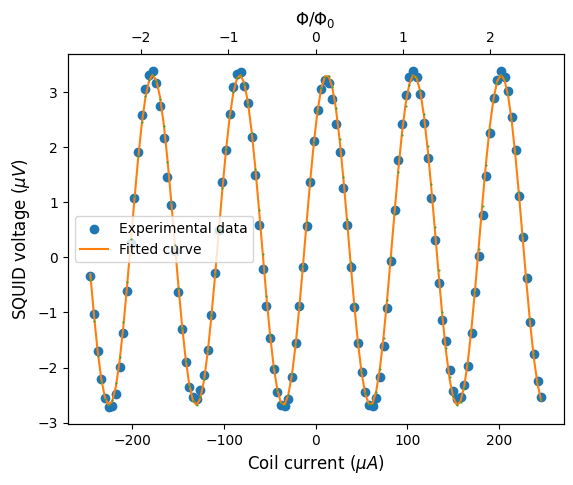

In [26]:
# Plot 1: Sine wave
plt.scatter(clipped_data["I (uA)"], clipped_data["V_s (uV)"], color ='C0', label='Experimental data')
plt.plot(clipped_data["I (uA)"], fit_function(clipped_data["I (uA)"], A, B, C, D), color ='C1', markersize=5, label='Fitted curve')
# plt.axvline(x=14.8, color='blue', linestyle='--', label=f'$I = 14.8 \mu A$')
plt.xlabel(r'Coil current $(\mu A)$', fontsize=12)
plt.ylabel(r'SQUID voltage $(\mu V)$', fontsize=12)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')

ax0 = plt.twiny()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax0.set_xlabel(r'$\Phi / \Phi_0$', color='black', fontsize=12)  # we already handled the x-label with ax1
ax0.plot(flux, fit_phi_function(flux, A, C, D), '.', color ='C2', markersize=1)

# plt.savefig('voltage_vs_flux.png', dpi=300) 
plt.show()